In [1]:
def get_api_key():
    import os
    from dotenv import load_dotenv
    # Unset OPENAI_API_KEY if it exists
    os.environ.pop('OPENAI_API_KEY', None)
    # Provide path and ignore currently set environment variable
    dotenv_path = '.env'
    load_dotenv(dotenv_path=dotenv_path, override=True)
    # Access the environment variable
    api_key = os.getenv('OPENAI_API_KEY')
    if api_key is None:
        print("API_KEY not found.")
    return api_key

In [2]:
# LangChain: Q&A over Documents

# An example might be a tool that would allow you to query a product catalog for items of interest.

# https://github.com/langchain-ai/langchain/issues/14585
# https://community.deeplearning.ai/t/l4-validation-error-while-running-response-index-query-query-llm-llm-replacement-model/563009/5
import openai
openai.api_key = get_api_key()
import langchain
import docarray
import tiktoken

import sys
print(f'python version = {sys.version}')

# import langchain_community
print(f'langchain version = {langchain.__version__}')
print(f'openai version = {openai.__version__}')
print(f'docarray version = {docarray.__version__}')
# print(f'LangChain Community Version = {langchain_community.__version__}')

python version = 3.11.6 (main, Feb  2 2024, 13:53:38) [GCC 11.4.0]
langchain version = 0.1.5
openai version = 1.10.0
docarray version = 0.32.1


In [3]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import CSVLoader
from langchain.vectorstores import DocArrayInMemorySearch
# Displaying information in Jupyter notebooks
from IPython.display import display, Markdown
from langchain.llms import OpenAI

In [4]:
file = 'OutdoorClothingCatalog_1000.csv'
loader = CSVLoader(file_path=file)
print(loader)

In [5]:
from langchain.indexes import VectorstoreIndexCreator

# DocArrayInMemorySearch is a in-memory vector store and it doesn't require connecting to an 
# external database of any kind so it makes it really easy to get started. 

# Create a vector store
# Specify the vector store class -> DocArrayInMemorySearch
# Which takes in a list of document loaders
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch
).from_loaders([loader])

/home/ypearson/.pyenv/versions/3.11.6/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.1.0 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [6]:
query ="Please list all your shirts with sun protection \
in a table in markdown and summarize each one."

In [7]:
llm_replacement_model = OpenAI(temperature=0, 
                               model='gpt-3.5-turbo-instruct')

response = index.query(query, 
                       llm = llm_replacement_model)


/home/ypearson/.pyenv/versions/3.11.6/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.openai.OpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  warn_deprecated(


In [8]:

'''
LLM's on documents

Moivation: We want to use LLMs to understand our documents, but LLM's can only inspect 
a few thousand words at a time. So if we have really large documents how can we get 
the language model to answer questions about everything that's in there?

This is where embeddings and vector stores come into play. 

Embeddings create numerical representation of pieces of text. This numerical representation
captures the sematic meaning of this text. Text with similar content will have similar vectors.
This lets us compare pieces of text in the vector space. 

Vector Database

A vector database is a way to store these vector representations that we created in the 
previous step. The way that we create this vector database is we populate it with chunks
of text coming from incoming documents. 

When we get a big incoming document, we're first going to break it up into smaller chunks.
This helps create pieces of text that are smaller than the original document, which is
useful because we may not be able to pass the whole document to the language model. 
So we want to create these small chunks so we can only pass the most **relevant** ones 
to the language model. We then create an embedding for each of these chunks, and then 
we store those in a vector database. That's what happens when we create the index. 
Now that we've got this index, we can use it during runtime to find the pieces of text 
most relevant to an incoming query. When a query comes in, we first create an embedding 
for that query. We then compare it to all the vectors in the vector database, and we pick 
the N most similar. These are then returned, and we can pass those in the prompt to the
language model to get back a final answer. 


'''


"\nLLM's on documents\n\nMoivation: We want to use LLMs to understand our documents, but LLM's can only inspect \na few thousand words at a time. So if we have really large documents how can we get \nthe language model to answer questions about everything that's in there?\n\nThis is where embeddings and vector stores come into play. \n\nEmbeddings create numerical representation of pieces of text. This numerical representation\ncaptures the sematic meaning of this text. Text with similar content will have similar vectors.\nThis lets us compare pieces of text in the vector space. \n\nVector Database\n\nA vector database is a way to store these vector representations that we created in the \nprevious step. The way that we create this vector database is we populate it with chunks\nof text coming from incoming documents. \n\nWhen we get a big incoming document, we're first going to break it up into smaller chunks.\nThis helps create pieces of text that are smaller than the original documen

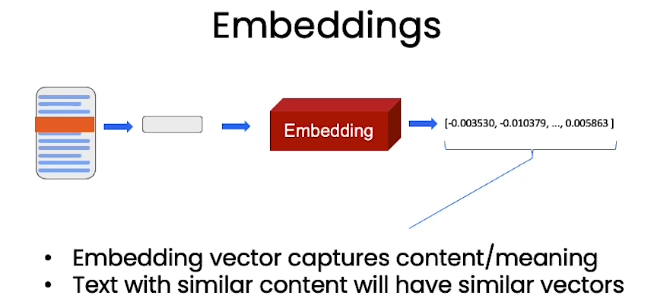

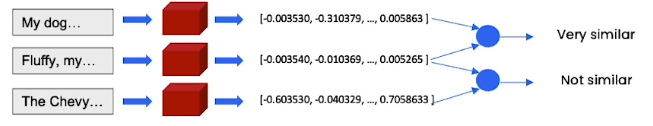

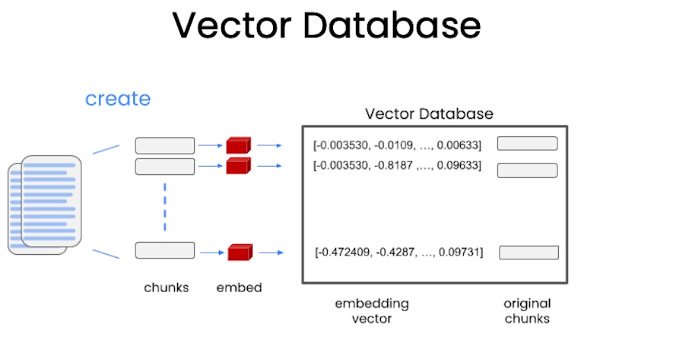

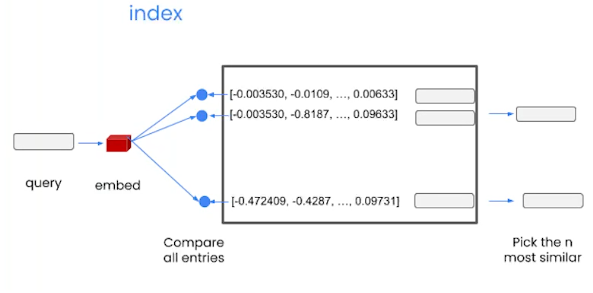

In [9]:
print(response)
display(Markdown(response))




| Name | Description | Sun Protection Rating |
| --- | --- | --- |
| Men's Tropical Plaid Short-Sleeve Shirt | Made of 100% polyester, UPF 50+ rated, wrinkle-resistant, front and back cape venting, two front bellows pockets, imported | SPF 50+, blocks 98% of harmful UV rays |
| Men's Plaid Tropic Shirt, Short-Sleeve | Made of 52% polyester and 48% nylon, UPF 50+ rated, SunSmart technology, wrinkle-free, front and back cape venting, two front bellows pockets, imported | SPF 50+, blocks 98% of harmful UV rays |
| Men's TropicVibe Shirt, Short-Sleeve | Made of 71% nylon and 29% polyester, UPF 50+ rated, wrinkle-resistant, front and back cape venting, two front bellows pockets, imported | SPF 50+, blocks 98% of harmful UV rays |
| Sun Shield Shirt | Made of 78% nylon and 22% Lycra Xtra Life fiber, UPF 50+ rated, moisture-wicking, fits comfortably over swimsuit, abrasion-resistant, imported | SPF




| Name | Description | Sun Protection Rating |
| --- | --- | --- |
| Men's Tropical Plaid Short-Sleeve Shirt | Made of 100% polyester, UPF 50+ rated, wrinkle-resistant, front and back cape venting, two front bellows pockets, imported | SPF 50+, blocks 98% of harmful UV rays |
| Men's Plaid Tropic Shirt, Short-Sleeve | Made of 52% polyester and 48% nylon, UPF 50+ rated, SunSmart technology, wrinkle-free, front and back cape venting, two front bellows pockets, imported | SPF 50+, blocks 98% of harmful UV rays |
| Men's TropicVibe Shirt, Short-Sleeve | Made of 71% nylon and 29% polyester, UPF 50+ rated, wrinkle-resistant, front and back cape venting, two front bellows pockets, imported | SPF 50+, blocks 98% of harmful UV rays |
| Sun Shield Shirt | Made of 78% nylon and 22% Lycra Xtra Life fiber, UPF 50+ rated, moisture-wicking, fits comfortably over swimsuit, abrasion-resistant, imported | SPF

In [10]:
# Step by step

In [11]:
'''
We're going to create a document loader, loading from that CSV with all the descriptions of 
the products that we want to do question answering over. We can then load documents from 
this document loader.  
'''

from langchain.document_loaders import CSVLoader
loader = CSVLoader(file_path=file)

In [12]:
docs = loader.load()

In [13]:
docs[0]

Document(page_content=": 0\nname: Women's Campside Oxfords\ndescription: This ultracomfortable lace-to-toe Oxford boasts a super-soft canvas, thick cushioning, and quality construction for a broken-in feel from the first time you put them on. \n\nSize & Fit: Order regular shoe size. For half sizes not offered, order up to next whole size. \n\nSpecs: Approx. weight: 1 lb.1 oz. per pair. \n\nConstruction: Soft canvas material for a broken-in feel and look. Comfortable EVA innersole with Cleansport NXT® antimicrobial odor control. Vintage hunt, fish and camping motif on innersole. Moderate arch contour of innersole. EVA foam midsole for cushioning and support. Chain-tread-inspired molded rubber outsole with modified chain-tread pattern. Imported. \n\nQuestions? Please contact us for any inquiries.", metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 0})

In [14]:
'''
we talked about creating chunks. Because these documents are already so small, we actually don't need to do any 
chunking here
'''

from langchain.embeddings import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

In [15]:
# This creates the overall numerical representation for this piece of text
embed = embeddings.embed_query("Hi my name is Harrison")

In [16]:
print(len(embed))

1536


In [17]:
print(embed[:5])

[-0.021935116222567927, 0.0067511968393128025, -0.018258349739335232, -0.03915192509902946, -0.013979244800643546]


In [18]:
# We want to create embeddings for all the pieces of text that we just loaddand then we also
# want to store them in a vector store. 

# We can do that by using the "from_documents" method on the vector store. This method takes
# in a list of documents, an embedding object, and then we'll create an overall vector store.
# We can now use this vector store to find pieces of text similar to an incoming query. 

# Vector store
vector_store_db = DocArrayInMemorySearch.from_documents(
    docs, 
    embeddings
)

In [19]:
query = "Please suggest a shirt with sunblocking"

In [20]:
# If we use the similarity search method on the vector store 
# and pass in a query, we will get back a list of documents. 

similar_documents = vector_store_db.similarity_search(query)

In [21]:
len(similar_documents)

4

In [22]:
similar_documents[0]

Document(page_content=': 255\nname: Sun Shield Shirt by\ndescription: "Block the sun, not the fun – our high-performance sun shirt is guaranteed to protect from harmful UV rays. \n\nSize & Fit: Slightly Fitted: Softly shapes the body. Falls at hip.\n\nFabric & Care: 78% nylon, 22% Lycra Xtra Life fiber. UPF 50+ rated – the highest rated sun protection possible. Handwash, line dry.\n\nAdditional Features: Wicks moisture for quick-drying comfort. Fits comfortably over your favorite swimsuit. Abrasion resistant for season after season of wear. Imported.\n\nSun Protection That Won\'t Wear Off\nOur high-performance fabric provides SPF 50+ sun protection, blocking 98% of the sun\'s harmful rays. This fabric is recommended by The Skin Cancer Foundation as an effective UV protectant.', metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 255})

In [23]:
'''
https://python.langchain.com/docs/modules/data_connection/retrievers/vectorstore

Vector store-backed retriever

A vector store retriever is a retriever that uses a vector store to retrieve documents. 
It is a lightweight wrapper around the vector store class to make it conform to the retriever 
interface. It uses the search methods implemented by a vector store, like similarity search and MMR, 
to query the texts in the vector store.
'''
retriever = vector_store_db.as_retriever()

In [24]:
# We want to do text generation and return a natural language response,
# we're going to import a language model and we're going to use ChatOpenAI

llm_model = "gpt-3.5-turbo"
llm = ChatOpenAI(temperature = 0.0, model=llm_model)

/home/ypearson/.pyenv/versions/3.11.6/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [25]:
'''
If we were doing this by hand, what we would do is we would combine the documents into a single 
piece of text. So we'd do something like this, where we join all the page content in the 
documents into a variable and then would pass this variable or a variant on the question, like, 
"Please list all your shirts with sun protection in a table in markdown and summarize each one." 
into the language model
'''

combined_document = "".join([similar_documents[i].page_content for i in range(len(similar_documents))])


In [26]:
response = llm.call_as_llm(f"{combined_document} Question: Please list all your \
shirts with sun protection in a table in markdown and summarize each one.") 


/home/ypearson/.pyenv/versions/3.11.6/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `call_as_llm` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


In [27]:
display(Markdown(response))

| Shirt Name                        | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [28]:
'''
All of those steps can be encapsulated with the LangChain chain. So here we can create a 
retrieval QA chain. This does retrieval and then does question answering over the retrieved documents.

We can create a retrieval QA chain

We'll pass in the language model. This will be used for doing the text generation at the end.

Next, we'll pass in the chain type. We're going to use "stuff". This is the simplest method as 
it just stuffs all the documents into context and makes one call to a language model.

Third, we're going to pass in a retriever. The retriever we created above is just an interface for 
fetching documents. This will be used to fetch the documents and pass it to the language model. 

Methods available: stuff, map_reduce, refine, and rerank

'''

qa_stuff = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=retriever, 
    verbose=True
)


In [29]:
'''
We can create a query and we can run the chain on this query. When we get the response, we can 
again display it using the display and markdown utilities.
'''


'\nWe can create a query and we can run the chain on this query. When we get the response, we can \nagain display it using the display and markdown utilities.\n'

In [30]:
query =  "Please list all your shirts with sun protection in a table \
in markdown and summarize each one."

In [31]:
response = qa_stuff.run(query)

/home/ypearson/.pyenv/versions/3.11.6/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new RetrievalQA chain...

> Finished chain.


In [32]:
display(Markdown(response))

| Shirt ID | Name                                   | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

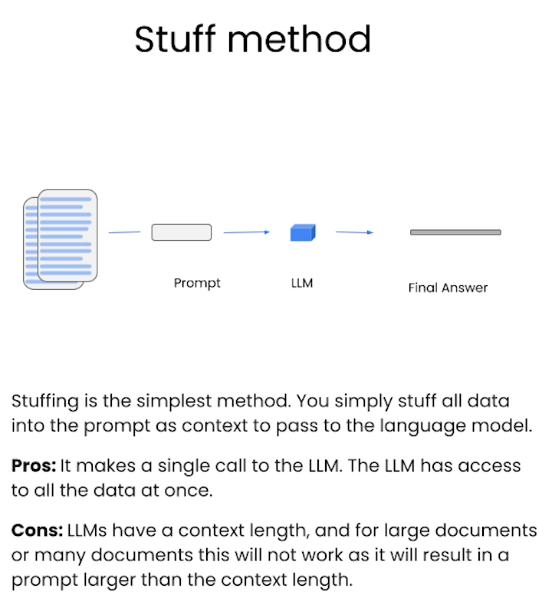

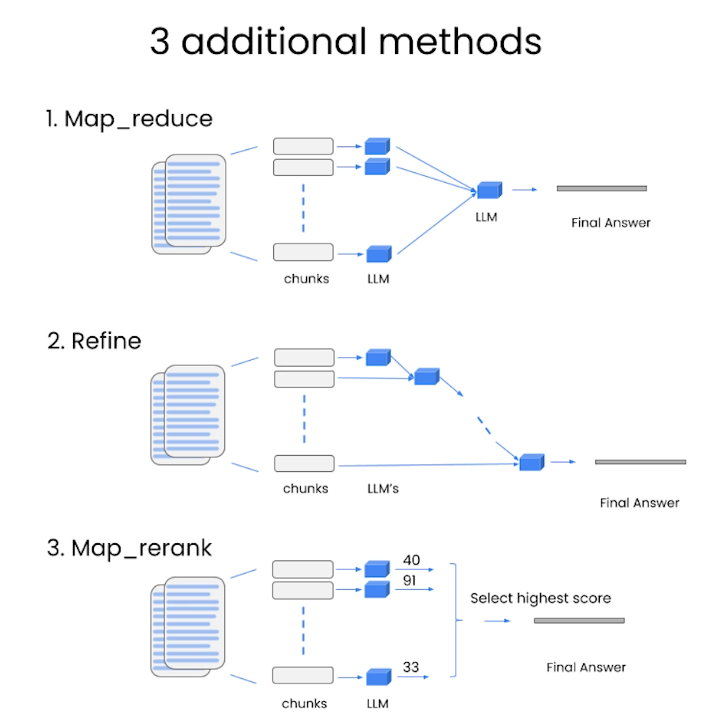